In [277]:
import pandas as pd
import numpy as np



from pythainlp.corpus.common import thai_stopwords
from pythainlp.tokenize import sent_tokenize
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.decomposition import PCA

import re
import string
import pickle
import os

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
from gensim.models import Doc2Vec

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud

import networkx as nx

from nltk import tokenize
from nltk.corpus import stopwords
import nltk

from operator import itemgetter
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('mari_dataset.csv')

In [113]:
df = pd.read_csv('mari_dataset.csv')
df['label_'] = df.label
df['label' ] = df.label.factorize()[0].tolist()
df.loc[df.label == 0].sample(5)[['text', 'label']]

,text,label
410,พี่ขอสอบถามค่าโทรทางไกลจากต่างประเทศค่ะ,0
6988,อยากรู้ว่าเอาเครื่องไปใช้ อินเตอร์เน็ต ที่ ประ...,0
2693,คือว่าจะเปิดระบบโทรทางไกลค่ะ,0
8284,ต้องการโทรทางไกลครับ,0
9415,สวัสดีคะ อยากจะเปิด เอ่อ โทรไปต่างประเทศคะ,0


## Text Clean

In [120]:

def clean_text(txt):
    
    
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    txt = re.sub(r'<.@*?!>','', txt)
    
    # ลบ hashtag
    txt = re.sub(r'#','',txt)

    # ลบ space
    txt = re.sub(r' ','',txt)
    
    #ลบ เลข
    txt = re.sub("(\d)", "",txt)
    
    txt = re.sub('""', "",txt)
    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        txt = re.sub(r'\{}'.format(c),'',txt)
    
    # ลบ separator เช่น \n \t
    txt = ' '.join(txt.split())

    
    return txt

df.text = df.text.apply(clean_text)

## Topic modelling

In [121]:
# initialise the count vectorizer

vectorizer = CountVectorizer(tokenizer = word_tokenize, ngram_range = (1, 2))

vectorised = vectorizer.fit_transform(df.text)

#print(vectorised)

In [432]:

# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 7, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
#display(df.head(10))

In [433]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df.text))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']
tmp_1 = tmp.loc[tmp['topic'] == tmp['topic'].unique()[3]].reset_index()
tmp_1.sort_values('relevance_score', ascending=False).head(20)

#display(tmp)

In [124]:
all_topics = pd.DataFrame([['1','2','3','4','5','6','7'],tmp['topic'].unique()]).T

all_topics.columns = ['Dominant_topic', 'topic_name']

In [ ]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    #tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])

In [447]:
results = df.groupby(['Dominant_topic', 'label']).count().reset_index()

results.Dominant_topic=results.Dominant_topic.astype(int)
all_topics.Dominant_topic = all_topics.Dominant_topic.astype(int)
results = results.merge(all_topics, on='Dominant_topic')
results['topic_name']# = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'label','text']]
graph_results = graph_results.pivot(index='topic_name', columns='label',values = 'text').reset_index()

graph_results.set_index('topic_name', inplace=True)
graph_results.columns = ['international dialing','other queries','lost and stolen','promotions','internet','billing and payment','true money']
topic_ = ['other','ยกเลิก','เบอร์','เงิน','สอบถาม','เติม','โทร']
graph_results.index = topic_
display(graph_results)

,international dialing,other queries,lost and stolen,promotions,internet,billing and payment,true money
other,49.0,250.0,13.0,375.0,293.0,1093.0,7.0
ยกเลิก,71.0,220.0,31.0,155.0,536.0,1202.0,13.0
เบอร์,29.0,181.0,29.0,252.0,138.0,190.0,152.0
เงิน,16.0,785.0,8.0,862.0,238.0,320.0,2.0
สอบถาม,48.0,162.0,74.0,300.0,75.0,578.0,2.0
เติม,18.0,130.0,7.0,247.0,168.0,354.0,16.0
โทร,110.0,98.0,13.0,93.0,144.0,181.0,NaN


Text(0.5, 1.0, 'label by topic')

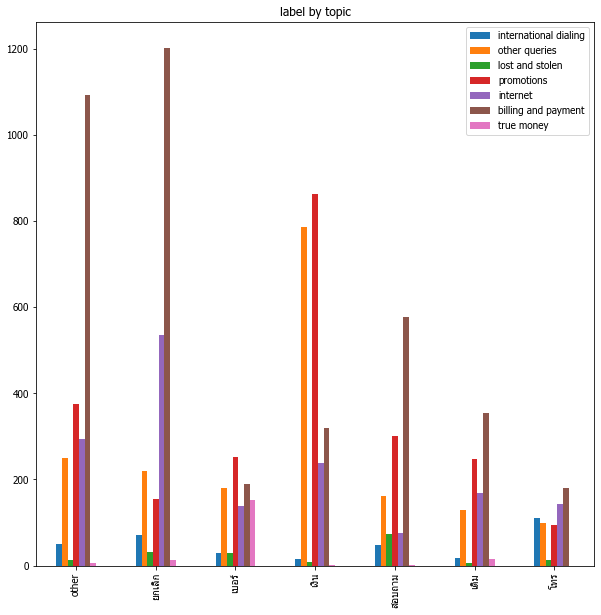

In [480]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
plt.title('label by topic')


## Length Density for each label

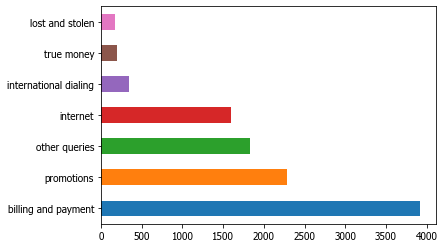

In [484]:
df.label_.value_counts().plot.barh(color = plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.show() 


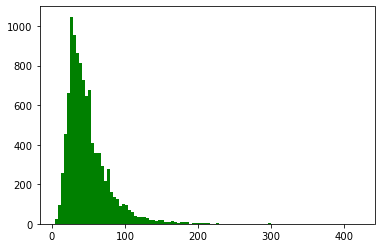

In [179]:
x = plt.hist(df.text.apply(len),bins=100,color = 'g')

In [170]:
df['text_len'] = df.text.apply(len)

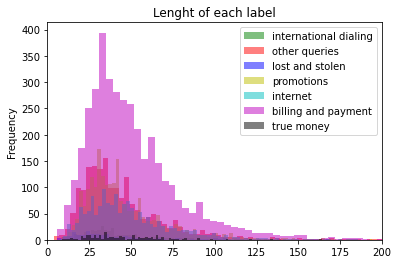

In [176]:
unique_label = df.label_.unique().tolist()
density_all = []
for i in unique_label:
    density_all.append(df.loc[df.label_==i, 'text_len'])

kwargs = dict(alpha=0.5, bins=100)

color = ['g','r','b', 'y','c', 'm', 'k']
for j in range(7):
    plt.hist(density_all[j], **kwargs, color=color[j], label=unique_label[j])
    plt.gca().set(title='Lenght of each label', ylabel='Frequency')
    plt.xlim(0,200)
    plt.legend();

## WordCloud

In [325]:
def get_text_str(message):
  tokenized =" "
  th_stw = thai_stopwords()
  for i in message:
    token = word_tokenize(i)
    for j in token:
      if j not in thai_stopwords():
        if j != ' ':
            tokenized =tokenized + " " + j
  
  return tokenized


text = get_text_str(df.text)

In [196]:
def plot_cloud(df):
    path = 'THSarabunNew/THSarabunNew.ttf'
    data = get_text_str(df)
    regexp = r"[ก-๙a-zA-Z']+"
    wordcloud = WordCloud(
                          font_path=path, 
                          min_font_size=1,
                          background_color="white",
                          width=400,
                          height=200,
                          max_words=1000, 
                          colormap='plasma', 
                          scale=3,
                          font_step=4, 
                          contour_color='steelblue', 
                          collocations=False,
                          regexp=regexp,
                          margin=2
                          ).generate(data)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.show()
    

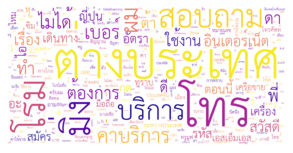

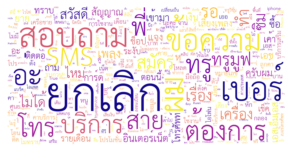

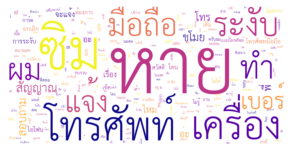

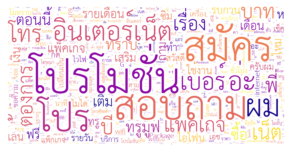

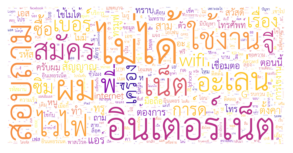

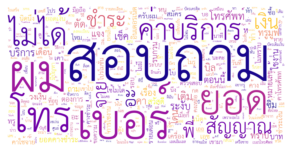

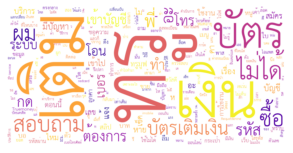

In [198]:
for i in range(7):
    plot_cloud(df= df.loc[df.label==i].text)

## Co-occurance Analysis

In [250]:
def keep_interest_pos(txt):
    
    _interest_tag = {
    # NOUN
    "NOUN","NCMN",
    "NTTL",
    "CNIT",
    "CLTV",
    "CMTR",
    "CFQC",
    "CVBL",
    "VACT",
    "VSTA",
    }
    pos_ = pos_tag(txt)
    keep_pos=[]
    for i in pos_:
        if i[1] in _interest_tag:
            keep_pos.append(i[0])
    txt_pos="" 
    for j in keep_pos:
        txt_pos +=" " + j
    return txt_pos[1:]
df['keep'] = df['text'].apply(word_tokenize).apply(keep_interest_pos)

In [221]:


def create_cooccurrence_matrix(sentences, window_size=4):
    
    import scipy
    import nltk

    vocabulary = {}
    data = []
    row = []
    col = []

    sentences = sentences.apply(word_tokenize)
    for sentence in sentences:
        for pos, token in enumerate(sentence):
            #print(pos,token)
            i = vocabulary.setdefault(token, len(vocabulary))
            start = max(0, pos-window_size)
            end = min(len(sentence), pos+window_size+1)
            for pos2 in range(start, end):
                if pos2 == pos:
                    continue
                j = vocabulary.setdefault(sentence[pos2], len(vocabulary))
                data.append(1.)
                row.append(i)
                col.append(j)

    cooccurrence_matrix_sparse = scipy.sparse.coo_matrix((data, (row, col)))
    return vocabulary, cooccurrence_matrix_sparse


In [251]:

vocabs,co_occ = create_cooccurrence_matrix(df.keep)
#print(0)
df_co_occ  = pd.DataFrame(co_occ.todense(),
                          index=vocabs.keys(),
                          columns = vocabs.keys())
#print(1)
df_co_occ = df_co_occ.sort_index()[sorted(vocabs.keys())]
#print(2)
#df_co_occ.style.applymap(lambda x: 'color: red' if x>0 else '')

In [252]:

font_list = fm.createFontList(['THSarabunNew/THSarabunNew.ttf'])  
fm.fontManager.ttflist.extend(font_list)



In [253]:
def visual_co_occ_matrix(keyword,top_co_occ = 20):
  ### keyword เป็น str ### 
  if keyword not in df_co_occ.columns:
        return "Error: Word not found, please insert word inside True domain"
  graph = nx.Graph()
  labels_params = {"font_family": "TH Sarabun New",
                 "alpha":1,
                 "font_size":20,
                 "with_labels": True}
  word =[]
  
  for i in df_co_occ.loc[keyword].sort_values(ascending = False).reset_index()['index'][:top_co_occ]:
    if i not in thai_stopwords():
      graph.add_edge(keyword,i)
      word.append(i)
      for j in df_co_occ.loc[i].sort_values(ascending = False).reset_index()['index'][:top_co_occ]:
        if j not in thai_stopwords():
          graph.add_edge(i,j)

  return nx.draw(graph,node_color='#00b4d9', **labels_params)

co-occurance of keyword ต่างประเทศ


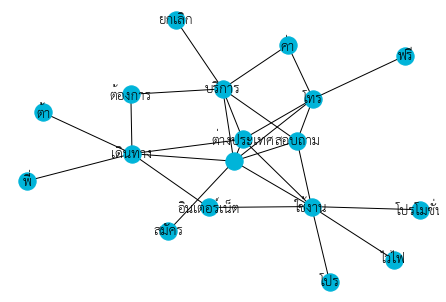

In [408]:
key_word = ["ต่างประเทศ", 'ยกเลิก', 'หาย','โปรโมชั่น','อินเตอร์เน็ต', 'สอบถาม','ทรู']

print('co-occurance of keyword '+key_word[0])
visual_co_occ_matrix(key_word[0],top_co_occ = 10)


co-occurance of keyword ยกเลิก


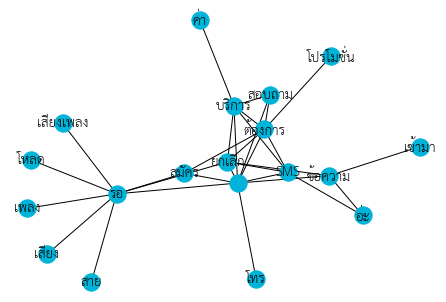

In [409]:
print('co-occurance of keyword '+key_word[1])
visual_co_occ_matrix(key_word[1],top_co_occ = 10)

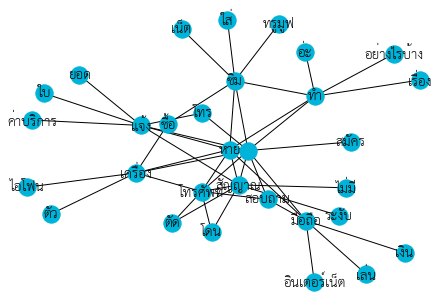

In [400]:
print('co-occurance of keyword '+key_word[2])
visual_co_occ_matrix(key_word[2],top_co_occ = 10)

co-occurance of keyword โปรโมชั่น


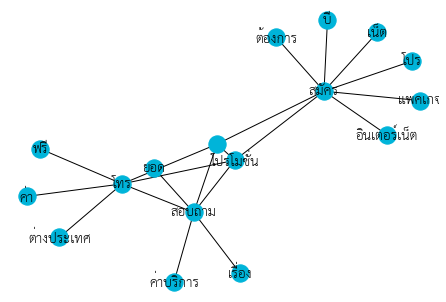

In [410]:
print('co-occurance of keyword '+key_word[3])
visual_co_occ_matrix(key_word[3],top_co_occ = 10)

co-occurance of keyword อินเตอร์เน็ต


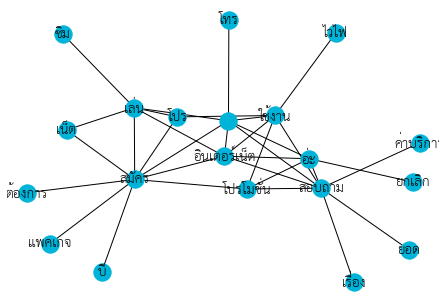

In [411]:
print('co-occurance of keyword '+key_word[4])
visual_co_occ_matrix(key_word[4],top_co_occ = 10)

co-occurance of keyword สอบถาม


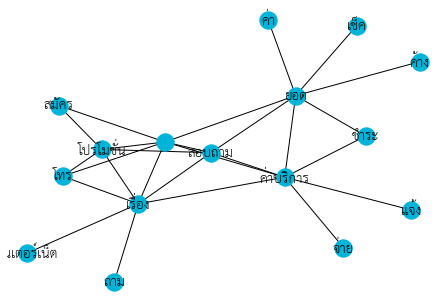

In [412]:
print('co-occurance of keyword '+key_word[5])
visual_co_occ_matrix(key_word[5],top_co_occ = 10)

co-occurance of keyword ทรู


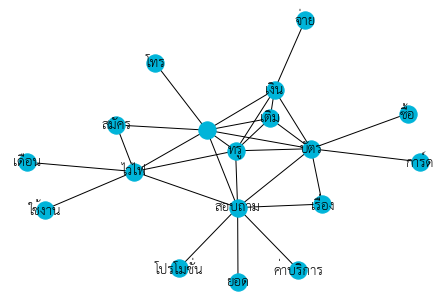

In [413]:
print('co-occurance of keyword '+key_word[6])
visual_co_occ_matrix(key_word[6],top_co_occ = 10)

## Keyword Extraction

In [368]:
def get_full_stop(txt):
    return txt + "."
def check_sent(word, sentences): 
    final = [all([w in x for w in word]) for x in sentences] 
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))
def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
    return result

In [388]:
def get_top_keyword(label,keyword):
    doc = get_text_str(df.loc[df.label_ == label].text.apply(get_full_stop))
    total_words = doc.split()
    total_word_length = len(total_words)
    total_sentences = tokenize.sent_tokenize(doc)
    total_sent_len = len(total_sentences)
    tf_score = {}
    for each_word in total_words:
        each_word = each_word.replace('.','')
        if each_word not in stop_words:
            if each_word in tf_score:
                tf_score[each_word] += 1
            else:
                tf_score[each_word] = 1
    tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())
    idf_score = {}
    for each_word in total_words:
        each_word = each_word.replace('.','')
        if each_word not in stop_words:
            if each_word in idf_score:
                idf_score[each_word] = check_sent(each_word, total_sentences)
            else:
                idf_score[each_word] = 1

    idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())
    tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}
    Keyword_ = get_top_n(tf_idf_score, keyword)
    plt.rcParams["font.family"]= 'Tahoma'
    plt.barh(*zip(*Keyword_.items()),color =plt.rcParams['axes.prop_cycle'].by_key()['color'])
    plt.title(label + ' Top ' + str(keyword) + ' keywords')
    plt.xlabel('keyword')
    plt.ylabel('tf_idf_score')
    plt.show()

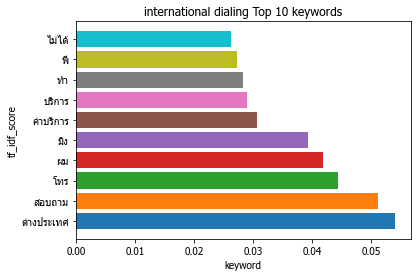

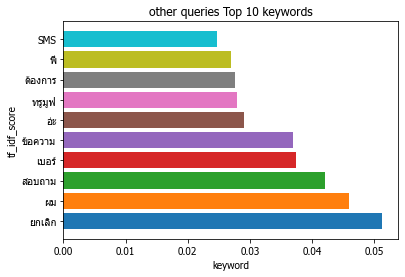

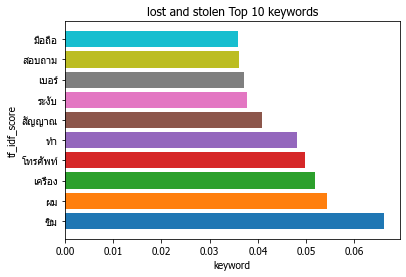

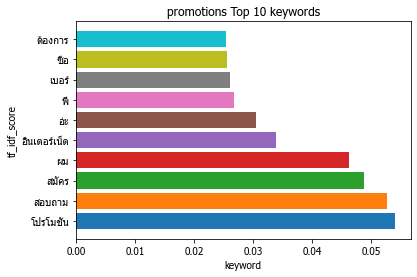

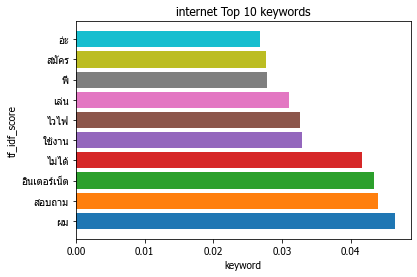

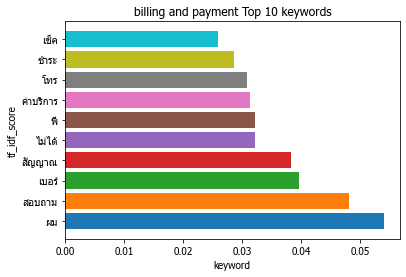

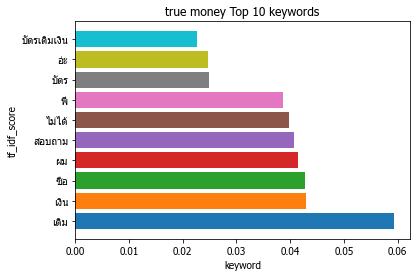

In [389]:
for i in df.label_.unique().tolist():
    get_top_keyword(i,10)

## clustering to find inside/outside domain

In [459]:
def get_text(txt):
    txt = word_tokenize(txt)
    tokenized ="" 
    for i in txt:
        if i != ' ':
            tokenized +=" " +i
    return tokenized[1:]
df['tokenized'] = df.text.apply(get_text)
tagged_data = [TaggedDocument(words=word_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(df.tokenized)]

In [462]:
max_epochs = 20
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Model Saved


In [465]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
#print("V1_infer", v1)

# to find most similar doc using tags
#similar_doc = model.docvecs.most_similar('1')
#print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
#print(model.docvecs['1'])

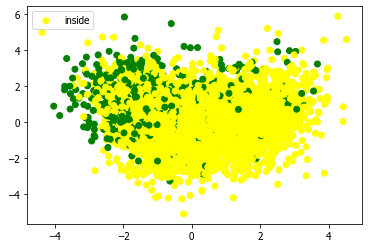

In [477]:
#kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100) 
agglo_model = AgglomerativeClustering(n_clusters=2,linkage='ward') 
X = agglo_model.fit(model.docvecs.doctag_syn0)
labels=agglo_model.labels_.tolist()
l = agglo_model.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080","#800010","#1000FF"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
# centroids = kmeans_model.cluster_centers_
# centroidpoint = pca.transform(centroids)
#plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c='#000000')
plt.legend(['inside','outside'])
plt.show()
